In [1]:
import numpy as np, random
from itertools import combinations

# Parameters
step_size    = 0.1
min_dist     = 3.0   # touching condition
max_dist     = 4.5   # maximum allowed center-to-center distance

def random_configuration(n):
    """
    Generate a random configuration for n nanoparticles with symmetry reduction:
      - NP1 fixed at (0,0,0)
      - NP2 fixed along the x-axis (between min_dist and max_dist)
      - NP3 in the xy-plane with y>0
    NP4 and NP5 (if needed) are placed randomly in full 3D.
    All interparticle distances must lie between min_dist and max_dist.
    """
    config = []
    # NP1 at origin
    config.append((0.0, 0.0, 0.0))
    
    if n >= 2:
        # NP2 on x-axis
        x = round(random.uniform(min_dist, max_dist), 1)
        config.append((x, 0.0, 0.0))
        
    if n >= 3:
        # NP3 in xy-plane (y > 0)
        placed = False
        for _ in range(1000):
            x = round(random.uniform(-max_dist, max_dist), 1)
            y = round(random.uniform(step_size, max_dist), 1)  # ensure y>0
            candidate = (x, y, 0.0)
            d1 = np.linalg.norm(np.subtract(candidate, config[0]))
            d2 = np.linalg.norm(np.subtract(candidate, config[1]))
            if min_dist <= d1 <= max_dist and min_dist <= d2 <= max_dist:
                config.append(candidate)
                placed = True
                break
        if not placed:
            return None  # failed to place NP3

    # For NP4 and NP5, choose random points in full 3D.
    while len(config) < n:
        candidate = (round(random.uniform(-max_dist, max_dist), 1),
                     round(random.uniform(-max_dist, max_dist), 1),
                     round(random.uniform(-max_dist, max_dist), 1))
        if candidate in config:
            continue
        if all(min_dist <= np.linalg.norm(np.subtract(candidate, p)) <= max_dist for p in config):
            config.append(candidate)
        # Prevent endless loops: if progress is too slow, abort.
        if len(config) < n and random.random() < 0.01:
            return None
    return tuple(config)

def canonical_invariant(config):
    """
    Compute a canonical invariant for the configuration.
    Here we use the sorted pairwise distances (rounded to 1 decimal)
    to identify equivalent (symmetric) configurations.
    """
    dists = sorted(np.linalg.norm(np.subtract(a, b)) for a, b in combinations(config, 2))
    return tuple(round(d, 1) for d in dists)

def sample_unique_configurations(n, target_samples):
    unique_configs = set()
    samples = 0
    trials = 0
    # Continue until we have target_samples unique configurations or we hit a trial limit.
    while samples < target_samples and trials < target_samples * 10:
        conf = random_configuration(n)
        trials += 1
        if conf is None:
            continue
        inv = canonical_invariant(conf)
        if inv not in unique_configs:
            unique_configs.add(inv)
            samples += 1
    return unique_configs

# Run the Monte Carlo sampler for 3, 4, and 5 NPs.
for n in [3, 4, 5]:
    uniq = sample_unique_configurations(n, target_samples=1000)
    print(f"{n} NPs: {len(uniq)} unique configurations sampled.")


3 NPs: 786 unique configurations sampled.
4 NPs: 1000 unique configurations sampled.
5 NPs: 35 unique configurations sampled.


C:\Users\bluml\AppData\Local\Temp\ipykernel_44976\918493122.py:7: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(center, radius=1.5, fill=True, color='blue', edgecolor='black', linewidth=1, alpha=0.6)


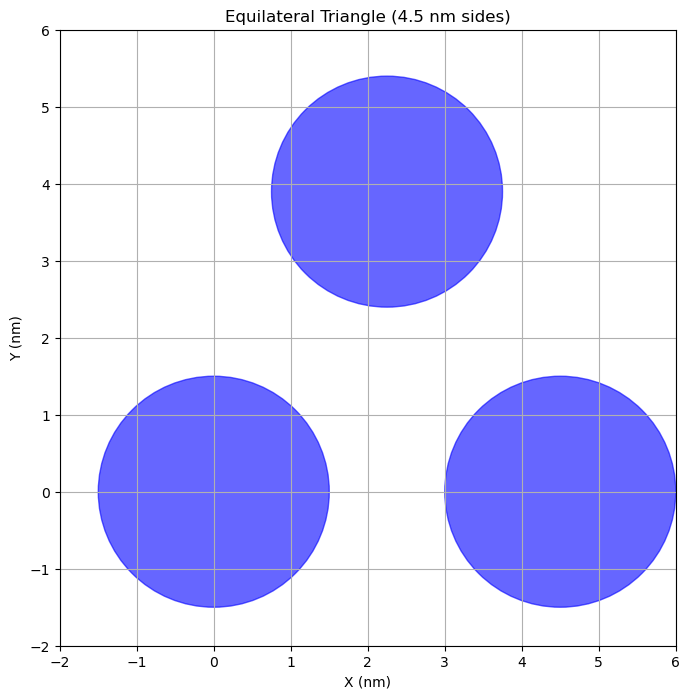

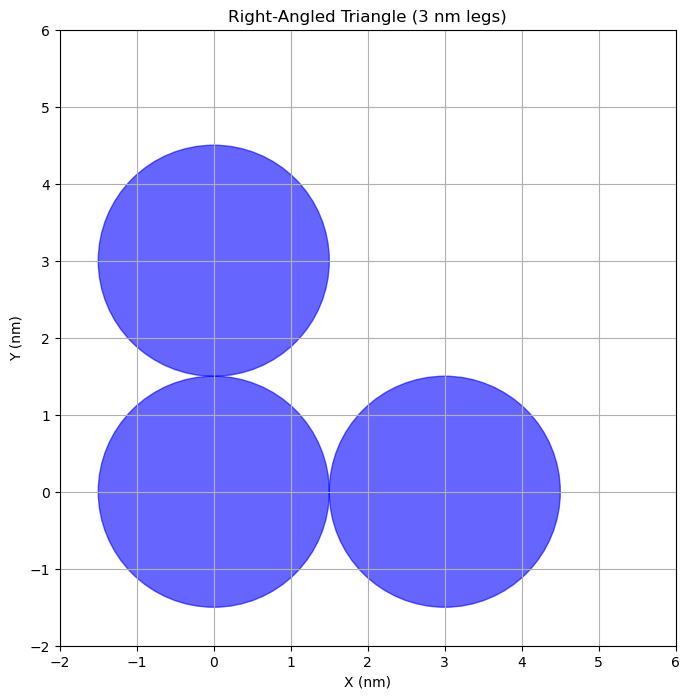

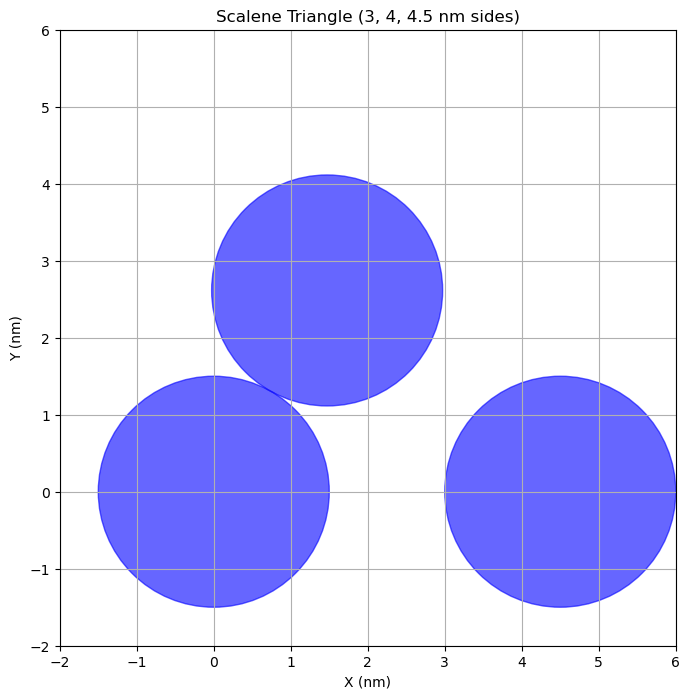

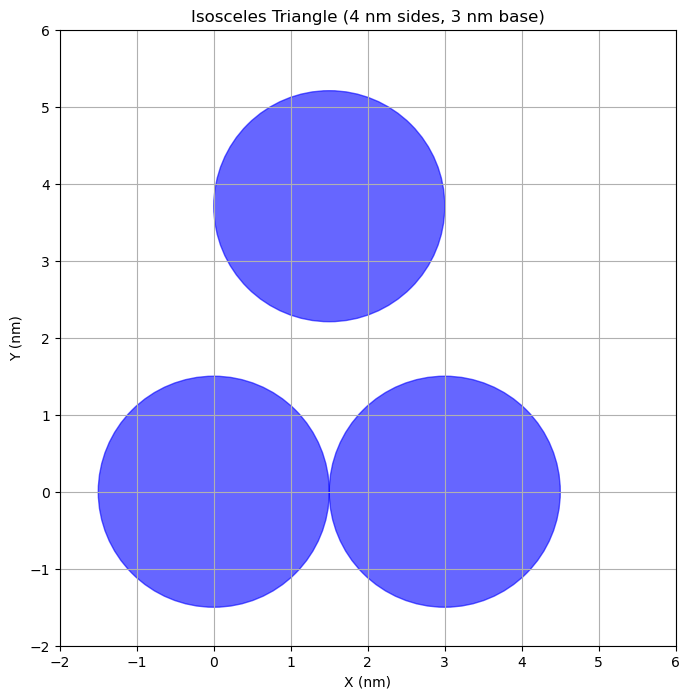

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_configuration(centers, title):
    fig, ax = plt.subplots(figsize=(8, 8))
    for center in centers:
        circle = plt.Circle(center, radius=1.5, fill=True, color='blue', edgecolor='black', linewidth=1, alpha=0.6)
        ax.add_patch(circle)
    ax.set_aspect('equal')
    ax.set_xlim(-2, 6)
    ax.set_ylim(-2, 6)
    ax.set_title(title)
    plt.xlabel('X (nm)')
    plt.ylabel('Y (nm)')
    plt.grid(True)
    plt.show()

# Equilateral Triangle (4.5 nm sides)
side = 4.5
centers_equilateral = [(0, 0), (side, 0), (side/2, (side * np.sqrt(3))/2)]
plot_configuration(centers_equilateral, "Equilateral Triangle (4.5 nm sides)")

# Right-Angled Triangle (3 nm legs)
a, b = 3, 3
centers_right = [(0, 0), (a, 0), (0, b)]
plot_configuration(centers_right, "Right-Angled Triangle (3 nm legs)")

# Scalene Triangle (3, 4, 4.5 nm sides)
d = 4.5
a, b = 3, 4
x = (d**2 - (b**2 - a**2)) / (2*d)
y = np.sqrt(a**2 - x**2)
centers_scalene = [(0, 0), (d, 0), (x, y)]
plot_configuration(centers_scalene, "Scalene Triangle (3, 4, 4.5 nm sides)")

# Isosceles Triangle (4 nm sides, 3 nm base)
base, side = 3, 4
height = np.sqrt(side**2 - (base/2)**2)
centers_isosceles = [(0, 0), (base, 0), (base/2, height)]
plot_configuration(centers_isosceles, "Isosceles Triangle (4 nm sides, 3 nm base)")

In [4]:
import numpy as np

step = 0.2  # nm
count = 0

# Valid center-to-center distance bounds (squared to avoid sqrt)
min_dist_sq = 3.0**2
max_dist_sq = 4.5**2

# Generate all possible positions for the third particle (C)
x = np.round(np.arange(-4.5, 4.5 + 1e-9, step), 1)
y = np.round(np.arange(-4.5, 4.5 + 1e-9, step), 1)
X, Y = np.meshgrid(x, y, indexing='ij')

# Precompute distance from A (0,0) to C for all grid points
AC_sq = X**2 + Y**2
mask_AC = (AC_sq >= min_dist_sq) & (AC_sq <= max_dist_sq)

# Iterate over possible distances for the second particle (B)
for d_AB in np.arange(3.0, 4.5 + 1e-9, step):
    d_AB = np.round(d_AB, 1)
    B_x = d_AB
    # Distance from B to C for all grid points
    BC_sq = (X - B_x)**2 + Y**2
    mask_BC = (BC_sq >= min_dist_sq) & (BC_sq <= max_dist_sq)
    # Count valid configurations for this d_AB
    count += np.sum(mask_AC & mask_BC)

print(f"Total distinct configurations: {count}")

Total distinct configurations: 1024


In [5]:
import numpy as np

step = 0.1  # nm
count = 0

# Valid center-to-center distance bounds (squared to avoid sqrt)
min_dist_sq = 3.0**2
max_dist_sq = 4.5**2

# Generate all possible positions for the third particle (C)
x = np.round(np.arange(-4.5, 4.5 + 1e-9, step), 1)
y = np.round(np.arange(-4.5, 4.5 + 1e-9, step), 1)
X, Y = np.meshgrid(x, y, indexing='ij')

# Precompute distance from A (0,0) to C for all grid points
AC_sq = X**2 + Y**2
mask_AC = (AC_sq >= min_dist_sq) & (AC_sq <= max_dist_sq)

# Iterate over possible distances for the second particle (B)
for d_AB in np.arange(3.0, 4.5 + 1e-9, step):
    d_AB = np.round(d_AB, 1)
    B_x = d_AB
    # Distance from B to C for all grid points
    BC_sq = (X - B_x)**2 + Y**2
    mask_BC = (BC_sq >= min_dist_sq) & (BC_sq <= max_dist_sq)
    # Count valid configurations for this d_AB
    count += np.sum(mask_AC & mask_BC)

print(f"Total distinct configurations: {count}")

Total distinct configurations: 8670
